# Subreddit Analysis Between Sci-Fi Fandoms
#### - Predicting user interests from reddit posts

## Problem Statement

Bandai is a Japanese toy company and producer of plastic model kits. Some of their most model kits are based on characters and vehicles from science fiction franchises such as Gundam and Star Wars. The Gundam franchise is an animated series that began in 1979 that takes place in a future setting where Earth has colonized space and large human piloted robots are used as weapons of war. Bandai produces models based on these robots in a variety of 'grades' of differing levels of size and complexity.  

Below is an example of a plastic model of a piloted robot from the Gundam franchise.

![Example of a plastic model of a piloted robot from the Gundam franchise.](assets/Gunpla-Expo-2013-144.jpg)

The Star Wars franchise is another science fiction franchise that features space wizard samurai as well as many spaceships and vehicles that are produced into model kits. 

Below is an example of one of these model kits (an x-wing spaceship).
![Example of Bandai Star Wars model.](assets/Bandai-Hobby-Star-Wars-X-Wing-Model-Kit-1.jpg)

Both of these science fiction franchises have their own subreddit forums on the site reddit.com. In these forums fans of each franchise discuss things related to the show such as their favorite characters or moments for instance. I will be looking at posts on each of these subreddits to search for any relevant insights.

Using submissions to the Gundam and Star Wars subreddits, can we build a model that could take a post from either subreddit and determine which one it came from? Will looking at the most commonly discussed terms or characters provide insight on new plastic model kits that could be produced that would be popular with fans?

To determine what subreddit a post is most likely to have come from I will compare the performance of multiple classification models: Random Forest, K-Nearest Neighbors, and Naive Bayes. These models will be compared by their accuracy compared to the baseline score, which would essentially be as good as placing a post with one of the two subreddits at random.

By determining the most common elements and words from the posts in each subreddit I hope to find enough evidence to recommend areas for Bandai to pursue when producing new plastic models from these franchises.


## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import spacy
from collections import Counter

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

plt.style.use('ggplot')

## Collecting and Reading in the data

The data used was collected from posts on two subreddit forums on the site reddit.com. The two subreddits used are r/gundam and r/starwars. The data was collected using a script that has already removed any posts that show up as deleted, removed, or have no text in them (usually just an image or article link). Since these posts would not be useful for the model I will be building they were removed before being saved to a csv file. The script is located under the filename 'toscrape.py' and can be used to scrape any target subreddit to a determined amount of posts, then remove the posts without text and save the results to csv.

In [2]:
# Reading in the two csv files created from scraping the subreddits

gundam = pd.read_csv('gundam_posts.csv')
starwars = pd.read_csv('starwars_posts.csv')

In [3]:
# Checking the first five rows of the gundam data
# There are a lot of rows included that will not be needed

gundam.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,is_gallery,media_metadata,author_flair_background_color,crosspost_parent,crosspost_parent_list,author_cakeday,banned_by,edited,distinguished,gilded
0,[],False,Cloak-Trooper-051020,NaN,[],NaN,text,t2_5dos6aoc,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,KnoobieExvius,NaN,[],NaN,text,t2_7szto48,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,necomus,NaN,[],NaN,text,t2_qln3mtr,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,BallisticDrizzt,NaN,[],NaN,text,t2_83gxum8b,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,SuperPamHan,NaN,[],NaN,text,t2_5wyucnxe,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning the data

First I need to narrow down the data to just look at the content of the posts and the subreddit that the post came from.

In [4]:
# Summary of the Gundam dataframe noting the amount of posts collected, eliminating the
# unnecessary columns, and looking for null values

print('Posts collected from Gundam subreddit:', gundam.shape[0])
print()
gundam = gundam[['subreddit', 'selftext']]
print('Null values in needed columns:')
gundam.isnull().sum()

Posts collected from Gundam subreddit: 2633

Null values in needed columns:


subreddit     0
selftext     14
dtype: int64

In [5]:
# Summary of the Star Wars dataframe noting the amount of posts collected, eliminating the
# unnecessary columns, and looking for null values

print('Posts collected from Star Wars subreddit:', starwars.shape[0])
print()
starwars = starwars[['subreddit', 'selftext']]
print('Null values in needed columns:')
starwars.isnull().sum()

Posts collected from Star Wars subreddit: 2558

Null values in needed columns:


subreddit     0
selftext     37
dtype: int64

I will need to drop any null values that remained in the data after gathering the posts from Reddit, when I collected the data using my script some posts with no text still made it through.

In [6]:
# Dropping null value posts from the data
gundam = gundam.dropna(axis = 0, subset = ['selftext'])
starwars = starwars.dropna(axis = 0, subset = ['selftext'])

print(f'New total posts from Gundam subreddit: {gundam.shape[0]}')
print(f'New total posts from Star Wars subreddit: {starwars.shape[0]}')

New total posts from Gundam subreddit: 2619
New total posts from Star Wars subreddit: 2521


In [7]:
# Checking for duplicate posts in the subreddits

print('Duplicates in Gundam:',
      (gundam['selftext'].value_counts() > 1).sum())
print('Duplicates in Star Wars:',
      (starwars['selftext'].value_counts() > 1).sum())

Duplicates in Gundam: 13
Duplicates in Star Wars: 11


In [8]:
# Dropping the duplicate posts from the dataframes

gundam.drop_duplicates(subset = ['selftext'], inplace = True)
starwars.drop_duplicates(subset = ['selftext'], inplace = True)

In [9]:
# Checking new total posts
print(f'New total posts from Gundam subreddit: {gundam.shape[0]}')
print(f'New total posts from Star Wars subreddit: {starwars.shape[0]}')

New total posts from Gundam subreddit: 2600
New total posts from Star Wars subreddit: 2499


In order to be able to predict which subreddit a post came from I will need to combine them into one dataframe and convert the subreddit column to a numeric value where 1 will indicate that the post came from one subreddit, and 0 will indicate that it came from the other subreddit.

In [10]:
# Combining the two dataframes into one

posts = pd.concat([gundam, starwars])
posts.reset_index(drop = True, inplace = True)
posts

,subreddit,selftext
0,Gundam,I’ve watched most of the stuff from the UC tim...
1,Gundam,Did I just wasted my time watching the OVA ins...
2,Gundam,I am fairly new to the Gundam franchise despit...
3,Gundam,\n\n[View Poll](https://www.reddit.com/poll/l8...
4,Gundam,Im new to gundam shows but not gunpla. I wante...
...,...,...
5094,StarWars,Let me begin my thoughts by saying I started w...
5095,StarWars,Is the reading order for The High Republic stu...
5096,StarWars,I met a strange group of people that speak Eng...
5097,StarWars,[removed]\n\n[View Poll](https://www.reddit.co...


In [11]:
posts = pd.get_dummies(posts, columns = ['subreddit'], drop_first = True)

In [12]:
posts.head()

,selftext,subreddit_StarWars
0,I’ve watched most of the stuff from the UC tim...,0
1,Did I just wasted my time watching the OVA ins...,0
2,I am fairly new to the Gundam franchise despit...,0
3,\n\n[View Poll](https://www.reddit.com/poll/l8...,0
4,Im new to gundam shows but not gunpla. I wante...,0


In [13]:
# Cleaning up post content

corpus = []
for i in range(posts.shape[0]):
    # Looking only for letters and eliminating punctuation, etc
    post = re.sub('[^a-zA-Z]', ' ', posts['selftext'][i])
    post = post.lower()
    post = post.split()
    
    # Stemming to look at root words
    ps = PorterStemmer()
    
    post = [ps.stem(word) for word in post if not word in set(stopwords.words('english'))]
    post = ' '.join(post)
    
    # Rejoining the cleaned post to new list
    corpus.append(post)

## Exploring the data

In [14]:
# Creating a dataframe of the individual words from all the posts

cv = CountVectorizer()

words = cv.fit_transform(corpus).toarray()

words_df = pd.DataFrame(words, columns = cv.get_feature_names())

words_df = words_df.transpose().sort_values(0, ascending=False).transpose()
words_df = pd.DataFrame(words_df)

In [15]:
# Adding the subreddit column to the posts

words_df['subreddit_StarWars'] = posts['subreddit_StarWars']

#### Reducing features

Since there are almost 15,000 words that appear in the posts I will look for the best words for each subreddit and look to reduce that number to somewhere between 70 and 90 in order to have better performing models.

In [16]:
# Pulling all of the words used in the subreddits

gundam_words = ' '.join(gundam['selftext'])
starwars_words = ' '.join(starwars['selftext'])

In [78]:
# Making a list of stop words where more can be added to eliminate some unneeded things like
# leftover links, etc...

stop_word_list = text.ENGLISH_STOP_WORDS.union(['http', 'https', 'www', 'com', 'webp',
                                                'reddit', 've', 'gundam', 'amp', 'like', 'just', 'know', 'think',
                                                'time', 'really', 'don', 'star', 'wars', 'jedi'])

In [79]:
# To narrow down the best words to use I will look use a tf-idf score to determine which words
# are more discriminating between subreddits

tvec = TfidfVectorizer(analyzer = 'word', stop_words = stop_word_list)
tvec.fit([gundam_words, starwars_words])

TfidfVectorizer(stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'amp', 'an', 'and', 'another', 'any',
                                      'anyhow', 'anyone', 'anything', 'anyway', ...}))

In [80]:
# Pulling the top 40 words for the Gundam subreddit

bestwords  = pd.DataFrame(tvec.transform([gundam_words, starwars_words]).todense(),
                   columns=tvec.get_feature_names(),
                   index=['Gundam', 'Star Wars'])
bestwords.T.sort_values('Gundam', ascending = False).head(40).T

,series,mobile,watch,poll,seed,good,zeta,uc,suit,unicorn,...,amuro,gunpla,format,redd,auto,preview,width,watched,ibo,x200b
Gundam,0.267400,0.198039,0.162261,0.154728,0.141154,0.131503,0.126597,0.120422,0.118008,0.117775,...,0.081163,0.077635,0.077521,0.076893,0.076893,0.076266,0.075952,0.075324,0.074988,0.074696
Star Wars,0.090441,0.002536,0.080862,0.125941,0.000000,0.102556,0.000000,0.000000,0.004508,0.000000,...,0.000000,0.000000,0.023103,0.019722,0.020004,0.019722,0.020568,0.053532,0.000000,0.063675


In [81]:
# Making a list from the top 40 words in the Gundam subreddit

g_word_list = list(bestwords.T.sort_values('Gundam', ascending = False).head(40).T.columns)
print(g_word_list)

['series', 'mobile', 'watch', 'poll', 'seed', 'good', 'zeta', 'uc', 'suit', 'unicorn', 'war', 'people', 'char', 'new', 'zeon', 'want', 'suits', 'ms', 'characters', 'does', 'watching', 'did', 'way', 'earth', 'story', 'character', 'got', 'anime', 'view', 'make', 'amuro', 'gunpla', 'format', 'redd', 'auto', 'preview', 'width', 'watched', 'ibo', 'x200b']


In [82]:
# Pulling the top 40 words for the Star Wars subreddit

bestwords.T.sort_values('Star Wars', ascending=False).head(40).T

,luke,force,anakin,new,order,people,poll,clone,sith,movies,...,character,palpatine,watch,ahsoka,lightsaber,does,empire,watching,yoda,view
Gundam,0.000000,0.014437,0.000000,0.107337,0.039545,0.112358,0.154728,0.009102,0.000942,0.028874,...,0.083798,0.000314,0.162261,0.000000,0.000000,0.097294,0.003766,0.094469,0.000000,0.082543
Star Wars,0.286695,0.201732,0.199974,0.170458,0.151299,0.133830,0.125941,0.124533,0.121433,0.121152,...,0.087060,0.083679,0.080862,0.079593,0.079197,0.078326,0.078326,0.074945,0.073258,0.072128


In [83]:
# Making a list from the top 40 words in the Star Wars subreddit

s_word_list = list(bestwords.T.sort_values('Star Wars', ascending = False).head(40).T.columns)
print(s_word_list)

['luke', 'force', 'anakin', 'new', 'order', 'people', 'poll', 'clone', 'sith', 'movies', 'mandalorian', 'republic', 'skywalker', 'movie', 'did', 'way', 'obi', 'good', 'vader', 'wan', 'make', 'rey', 'episode', 'want', 'trilogy', 'love', 'series', 'dark', 'characters', 'story', 'character', 'palpatine', 'watch', 'ahsoka', 'lightsaber', 'does', 'empire', 'watching', 'yoda', 'view']


In [84]:
# Creating a list of the best words to use in order to reduce features.
# To prevent any overlap I'm converting the list to a set then back to a list.

best_words_list = g_word_list + s_word_list

unique_best_words = set(best_words_list)

best_words_list = list(unique_best_words)

print(f'There are now {len(best_words_list)} best words to use.')

There are now 64 best words to use.


Now that I know the words that should be used, I will set the words dataframe to use just these words.

In [85]:
# Creating a new count vectorizer matrix of words and setting it to only contain the best

cv = CountVectorizer()

words = cv.fit_transform(posts['selftext']).toarray()

words_df = pd.DataFrame(words, columns = cv.get_feature_names())

words_df = words_df.transpose().sort_values(0, ascending=False).transpose()
words_df = pd.DataFrame(words_df)

In [86]:
words_df = words_df[best_words_list]
words_df['subreddit_StarWars'] = posts['subreddit_StarWars']
words_df

,luke,good,earth,rey,watching,redd,watch,view,char,auto,...,ibo,order,mandalorian,poll,character,got,vader,force,obi,subreddit_StarWars
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,2,2,0,1,2,0,0,0,0,0,...,0,2,0,0,2,1,0,1,0,1
5095,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
5097,0,0,0,0,0,0,0,1,0,0,...,0,0,0,2,0,0,0,0,0,1


### Plotting the Most Common Words in Each Subreddit

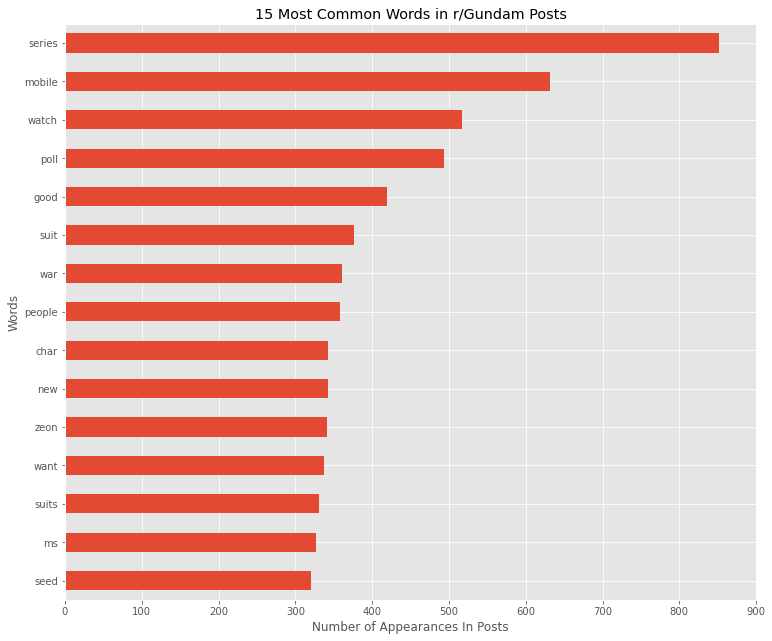

In [93]:
a = plt.figure(figsize = (12, 10))
axes = a.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlim([0, 900])
words_df[words_df['subreddit_StarWars'] == 0].sum().sort_values(
    ascending = False).head(15).sort_values(ascending = True).plot(kind = 'barh')
plt.xlabel('Number of Appearances In Posts')
plt.ylabel('Words')
plt.title('15 Most Common Words in r/Gundam Posts');

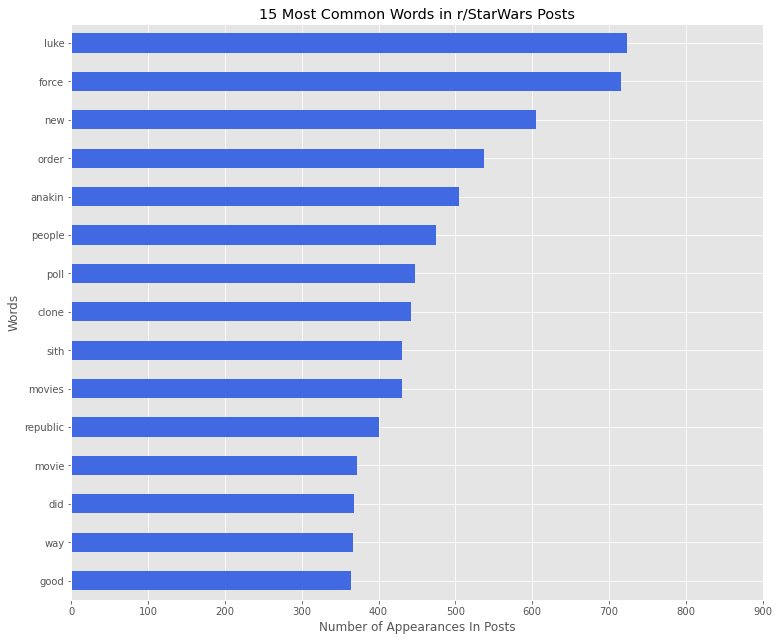

In [92]:
a = plt.figure(figsize = (12, 10))
axes = a.add_axes([0.1,0.1,0.8,0.8])
words_df[words_df['subreddit_StarWars'] == 1].drop(columns = 'subreddit_StarWars').sum().sort_values(
    ascending = False).head(15).sort_values(ascending = True).plot(kind = 'barh', color = 'royalblue')
axes.set_xlim([0, 900])
plt.xlabel('Number of Appearances In Posts')
plt.ylabel('Words')
plt.title('15 Most Common Words in r/StarWars Posts');

### Checking For Popular Characters

In [46]:
# Creating a list of character names from the posts in r/Gundam

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 1500000
doc = nlp(' '.join(gundam['selftext']))

gundam_char_list = []

for ent in doc.ents:
    if ent.label_ == 'PERSON' and 'http' not in ent.text:
        gundam_char_list.append(ent.text)

gundam_char_list

['Gundam',
 'Netflix',
 'Zaku',
 'Char',
 'Gundam Thunderbolt',
 'Warhammer',
 'Toru Furuya',
 "Toru Furuya's",
 'Amuro Ray',
 'Tuxedo Mask',
 'Ribbons Almark',
 'Ribbons Almark',
 'Amuro Ray',
 'Furuya',
 'Noboru Sogetsu',
 "Noboru Sogetsu's",
 'Nahel Argama',
 'Dogosse',
 'Gundam Manga',
 'Gundam SEED',
 'Laura',
 'Char',
 'Hayato',
 'Gundam',
 'Garma Zabi',
 'Gundam',
 'Alex',
 'Gundam Prototype',
 'Zeon',
 'Gundam',
 'Gundam',
 'Gurren Lagann',
 'Naruto',
 'Piece',
 'Zaku Kai',
 'Al',
 'Al',
 'Zeon ace',
 'Gundam Alex',
 'Gundam Unicorn',
 'Gundam Seed',
 'Gundam Seed',
 'Kira',
 'Kira',
 'Kira',
 'Kira',
 'Lacus Clyne',
 'Lacus',
 'Gundam Narrative',
 'Jora',
 'quit!&lt',
 'Seed',
 'kinda',
 'Audrey',
 'Banagher',
 'Iok',
 'Martha',
 'Audrey',
 'Audrey',
 'Audrey',
 'Banagher',
 'Cameron Bloom',
 'Hitler',
 'Zeon',
 'Logan',
 'Run',
 'haman',
 'Gunpla',
 'Hathaway',
 'AU',
 'Jonouchi',
 'Char',
 'Jack',
 'Jonouchi',
 'Jack',
 'Jonouchi',
 'Gundam',
 'Zaku',
 'Guntank',
 'Gundam X'

In [47]:
# Counting the number of times that characters are mentioned and preparing to create a dataframe

gundam_char_dict = Counter(gundam_char_list)

chars_list = []

for char, num in gundam_char_dict.items():
    chars_list.append([char, num])

chars_list

[['Gundam', 431],
 ['Netflix', 11],
 ['Zaku', 49],
 ['Char', 105],
 ['Gundam Thunderbolt', 6],
 ['Warhammer', 1],
 ['Toru Furuya', 1],
 ["Toru Furuya's", 1],
 ['Amuro Ray', 16],
 ['Tuxedo Mask', 1],
 ['Ribbons Almark', 2],
 ['Furuya', 1],
 ['Noboru Sogetsu', 1],
 ["Noboru Sogetsu's", 1],
 ['Nahel Argama', 1],
 ['Dogosse', 1],
 ['Gundam Manga', 1],
 ['Gundam SEED', 35],
 ['Laura', 3],
 ['Hayato', 4],
 ['Garma Zabi', 1],
 ['Alex', 5],
 ['Gundam Prototype', 1],
 ['Zeon', 106],
 ['Gurren Lagann', 2],
 ['Naruto', 2],
 ['Piece', 1],
 ['Zaku Kai', 1],
 ['Al', 8],
 ['Zeon ace', 1],
 ['Gundam Alex', 2],
 ['Gundam Unicorn', 26],
 ['Gundam Seed', 17],
 ['Kira', 101],
 ['Lacus Clyne', 4],
 ['Lacus', 15],
 ['Gundam Narrative', 3],
 ['Jora', 1],
 ['quit!&lt', 1],
 ['Seed', 11],
 ['kinda', 7],
 ['Audrey', 7],
 ['Banagher', 32],
 ['Iok', 6],
 ['Martha', 3],
 ['Cameron Bloom', 1],
 ['Hitler', 5],
 ['Logan', 1],
 ['Run', 1],
 ['haman', 1],
 ['Gunpla', 47],
 ['Hathaway', 8],
 ['AU', 2],
 ['Jonouchi', 3],

In [48]:
# Setting up a dataframe with the character names and number of times mentioned

gundam_chars_df = pd.DataFrame(chars_list, columns = ['character', 'mentions'])

In [66]:
gundam_chars_df[gundam_chars_df['character'] == 'Amuro']

,character,mentions
101,Amuro,108


In [54]:
gundam_chars_df[gundam_chars_df['character'] == 'Amuro Ray']

,character,mentions
8,Amuro Ray,16


In [74]:
# Adding the "Amuro Ray" row to the "Amuro" row(108 + 16 = 124)
gundam_chars_df.loc[101, 'mentions'] = 124

In [75]:
gundam_chars_df.iloc[101]

character    Amuro
mentions       124
Name: 101, dtype: object

In [76]:
# Dropping indexes that are not actually characters and creating a top 10 dataframe to plot
# 0 - Gundam (Name of franchise/type of robot)
# 23 - Zeon (A faction)
# 2 - Zaku (Type of robot)
# 50 - Gunpla (short way to refer to "Gundam Plastic Models")
# 17 - Gundam SEED (Name of one of the shows in the franchise)
# 237 - Archangel (Type of spaceship)
# 31 - Gundam Unicorn (Specific type of Gundam robot)
# 108 - Neo Zeon (A faction)
# 272 - Gundams (type of robot)
# 69 - Gundam Wing (Name of show/type of gundam robot)
# 309 - Rey (Amuro's last name, he would appear twice)

top_10_gundam_chars = gundam_chars_df.drop([0,23,2,50,17,237,31,108,272,69,309],
                                           axis = 0).sort_values(by = 'mentions',
                                                                 ascending = False).head(10)
top_10_gundam_chars

,character,mentions
101,Amuro,124
3,Char,105
33,Kira,101
222,Setsuna,38
42,Banagher,32
553,Hiroto,20
305,Cagalli,19
679,Minerva,19
512,Syam,19
248,Eldora,19


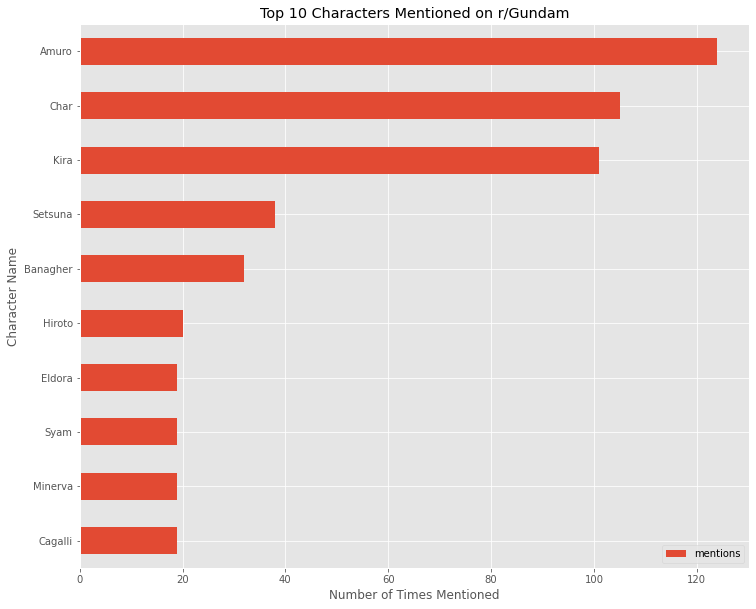

In [77]:
top_10_gundam_chars.sort_values(by = 'mentions',
                                ascending = True).plot(kind = 'barh',
                                                       x='character',
                                                       y='mentions',
                                                       figsize = (12, 10))
plt.title('Top 10 Characters Mentioned on r/Gundam')
plt.ylabel('Character Name')
plt.xlabel('Number of Times Mentioned');

In [94]:
# Creating a list of character names from the posts in r/StarWars

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 1500000
doc = nlp(' '.join(starwars['selftext']))

starwars_char_list = []

for ent in doc.ents:
    if ent.label_ == 'PERSON' and 'http' not in ent.text:
        starwars_char_list.append(ent.text)

starwars_char_list

['Ben',
 'A. baby yoda',
 'C.',
 'Ben',
 'Tarre Viszla',
 'Tarre',
 'Roh',
 'Maul',
 'George Lucas',
 'Darth Plagueis',
 'JJ Abrams',
 "George Lucas Director's",
 'Mary Poppins',
 'Luke',
 'Mark Hamill',
 'JJ Abrams',
 'Darth Plagueis',
 'Darth Plageuis',
 'Plageuism',
 'Anakin',
 'Obi Wan',
 'Obi Wan',
 'Plageuis',
 'Anakin',
 'Ray',
 'George Lucas',
 'ROS',
 'Padme',
 'Plo Koon\n',
 'Cal Kestis',
 'Mace Windu',
 'Battle',
 'Anakin',
 'Obi Wan rescue Palpatine',
 'Anakin',
 'Trennis',
 'Yoda',
 'Wan',
 'Luke',
 'Rey',
 'Rey',
 'Rey',
 'Rey',
 'Ben',
 'Ben',
 'Ben',
 'Rey',
 'Rey',
 'Rey',
 'Ben',
 'Luke',
 'Rey',
 'Luke',
 'Luke',
 'Rey',
 'Rey',
 'Rey',
 'Rey',
 'Rey',
 'Luke',
 'Leia',
 'Rey',
 'Luke',
 'Leia',
 'Jedi',
 'Rey',
 'Jedi (Yoda',
 'Obi Wan',
 'Rey',
 'Luke',
 'Leia',
 'Rey',
 'Luke',
 'Leia',
 'Rey',
 'Ben',
 'Luke',
 'Leia',
 'Ben',
 'Rey',
 'Luke',
 'Leia',
 'Luke',
 'Leia',
 'Luke',
 'Luke',
 'Ben',
 'Luke',
 'Leia',
 'Rey',
 'Luke',
 'Luke',
 'Rey',
 'Leia',
 'Luke'

In [95]:
# Counting the number of times that characters are mentioned and preparing to create a dataframe

starwars_char_dict = Counter(starwars_char_list)

starwars_chars_list = []

for char, num in starwars_char_dict.items():
    starwars_chars_list.append([char, num])

starwars_chars_list

[['Ben', 94],
 ['A. baby yoda', 1],
 ['C.', 1],
 ['Tarre Viszla', 1],
 ['Tarre', 1],
 ['Roh', 1],
 ['Maul', 15],
 ['George Lucas', 40],
 ['Darth Plagueis', 10],
 ['JJ Abrams', 5],
 ["George Lucas Director's", 1],
 ['Mary Poppins', 1],
 ['Luke', 502],
 ['Mark Hamill', 8],
 ['Darth Plageuis', 1],
 ['Plageuism', 1],
 ['Anakin', 116],
 ['Obi Wan', 38],
 ['Plageuis', 2],
 ['Ray', 4],
 ['ROS', 2],
 ['Padme', 30],
 ['Plo Koon\n', 1],
 ['Cal Kestis', 8],
 ['Mace Windu', 28],
 ['Battle', 3],
 ['Obi Wan rescue Palpatine', 1],
 ['Trennis', 1],
 ['Yoda', 125],
 ['Wan', 4],
 ['Rey', 296],
 ['Leia', 110],
 ['Jedi', 72],
 ['Jedi (Yoda', 1],
 ['Link', 1],
 ['Count Dooku', 6],
 ['Dooku', 51],
 ['Clone Wars', 6],
 ['Jar Jar', 3],
 ['Darth Vader', 55],
 ['Jacen Solo', 2],
 ['Mara Jade', 6],
 ['Ahmed Best', 3],
 ['Frank Oz', 1],
 ['Kenny Baker', 1],
 ['Ewen', 1],
 ['Samuel Jackson', 1],
 ['Natalie Portman', 2],
 ['Darth', 10],
 ['Obi-Wan', 98],
 ['Palps', 1],
 ['Mandalore', 10],
 ['Captain Rex', 2],
 ['Qu

In [96]:
# Setting up a dataframe with the character names and number of times mentioned

starwars_chars_df = pd.DataFrame(starwars_chars_list, columns = ['character', 'mentions'])

In [97]:
# Dropping indexes that are not actually characters and creating a top 10 dataframe to plot
# 32 - Jedi (Order of space wizard samurai)
# Although 'Mando' is a shortened version of 'Mandalorian', which is a group I will leave it
# in this dataframe as the main character in the show 'The Mandalorian' is typically refered to
# as 'Mando' in the show.
# 'Obi-Wan' and 'Ben' could technically be refering to the same character, though there is also 
# another main character named Ben Solo(Kylo Ren) so I will leave this in the dataframe.

top_10_starwars_chars = starwars_chars_df.drop(32, axis = 0).sort_values(by = 'mentions',
                                                                 ascending = False).head(10)
top_10_starwars_chars

,character,mentions
12,Luke,502
30,Rey,296
28,Yoda,125
16,Anakin,116
31,Leia,110
49,Obi-Wan,98
0,Ben,94
88,Grogu,68
39,Darth Vader,55
126,Mando,53


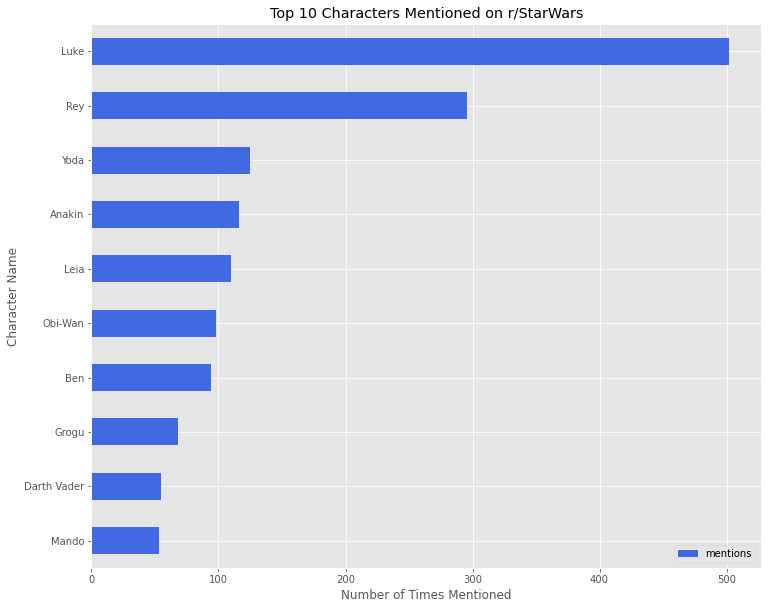

In [98]:
top_10_starwars_chars.sort_values(by = 'mentions',
                                ascending = True).plot(kind = 'barh',
                                                       x='character',
                                                       y='mentions',
                                                       color = 'royalblue',
                                                       figsize = (12, 10))
plt.title('Top 10 Characters Mentioned on r/StarWars')
plt.ylabel('Character Name')
plt.xlabel('Number of Times Mentioned');

## Setting up the models

In [99]:
# Setting the X and y for the model

X = words_df.drop(columns = 'subreddit_StarWars')
y = words_df['subreddit_StarWars']

In [100]:
# Establishing a baseline score, which is the percentage of the majority class, to compare to model performance

y.value_counts(normalize = True)

0    0.509904
1    0.490096
Name: subreddit_StarWars, dtype: float64

The majority class is posts from r/Gundam with 50.9% of the values, so the baseline accuracy for the models to beat is 50.9%

In [101]:
# Splitting into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 31)

#### Random Forest

In [102]:
# Running a model using Random Forest

forest = RandomForestClassifier(random_state = 31)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=31)

In [103]:
# Predicting results

y_pred = forest.predict(X_test)

In [104]:
forest.score(X_train, y_train)

0.8540794979079498

Random Forest Confusion Matrix:
[[538 110]
 [164 463]]
Random Forest accuracy: 0.7850980392156863


<Figure size 576x576 with 0 Axes>

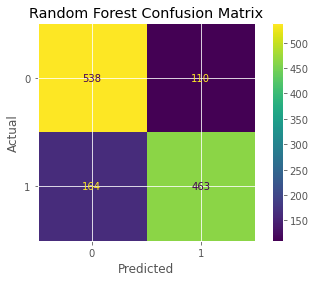

In [105]:
forest_cm = confusion_matrix(y_test, y_pred)
print('Random Forest Confusion Matrix:')
print(forest_cm)
print(f'Random Forest accuracy: {accuracy_score(y_test, y_pred)}')
plt.figure(figsize = (8,8))
plot_confusion_matrix(forest, X_test, y_test)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

#### K-Nearest Neighbors

In [106]:
# Setting up K-Nearest Neighbors model

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [107]:
knn_pred = knn.predict(X_test)

In [108]:
knn.score(X_train, y_train)

0.759152719665272

KNN Confusion Matrix:
[[390 119]
 [258 508]]
K-Nearest Neighbors accuracy: 0.7043137254901961


<Figure size 576x576 with 0 Axes>

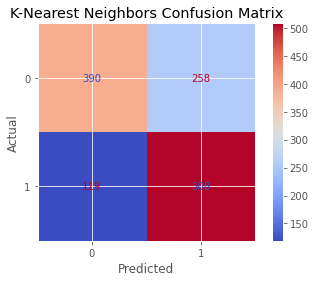

In [109]:
knn_cm = confusion_matrix(knn_pred, y_test)
print('KNN Confusion Matrix:')
print(knn_cm)
print(f'K-Nearest Neighbors accuracy: {accuracy_score(y_test, knn_pred)}')
plt.figure(figsize = (8,8))
plot_confusion_matrix(knn, X_test, y_test, cmap='coolwarm')
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

#### Naive Bayes

In [110]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [111]:
nb_pred = nb.predict(X_test)

In [112]:
nb.score(X_train, y_train)

0.7625523012552301

Naive Bayes accuracy: 0.7631372549019608
Naive Bayes Confusion Matrix:
[[639 293]
 [  9 334]]


<Figure size 576x576 with 0 Axes>

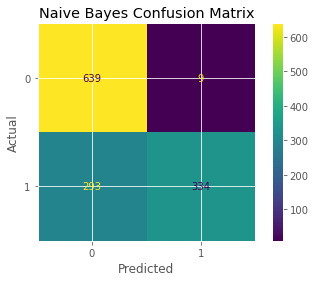

In [113]:
nb_cm = confusion_matrix(nb_pred, y_test)
print(f'Naive Bayes accuracy: {accuracy_score(y_test, nb_pred)}')
print('Naive Bayes Confusion Matrix:')
print(nb_cm)
plt.figure(figsize = (8,8))
plot_confusion_matrix(nb, X_test, y_test)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

## Evaluation

The random forest model correctly predicted 84% of the test data into the corresponding subreddit. This was a better result than both the Naive Bays and KNN models that, which both had a much better accuracy than the baseline but performed slightly worse than the random forest model at 79.9% and 82.9% respectively.

There are many words that are common to both subreddits, these are words such as 'like', 'would', 'want', 'get', and 'character', which all show up in the top 15 words in each subreddit.

An interesting takeaway is that the word "poll" is quite common in the Gundam subreddit, appearing about 500 times in the 2600 posts collected. This could be worth further investigation in another project to see what users on the subreddit are polling about. These polls could show trends in aspects of the franchise that are popular with subreddit users.

## Conclusion

All tests perform better than the baseline score and are able to predict which subreddit a post most likely originated from.  Each subreddit shows preferences for certain characters which would mean that plastic model kits that are related with those characters could be more popular with fans. With two characters from the Star Wars show 'The Mandalorian' showing up in the top 10 characters mentioned on the subreddit, it could be a good idea for Bandai to release a plastic model kit based on the show.